# Importing Required Libraries

In [2]:
import numpy as np
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow
from keras.datasets import cifar100
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from skimage.feature import hog
import copy
from tqdm import tqdm
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
# from google.colab import drive
# drive.mount('/content/gdrive')
# from google.colab import files

from skimage import color

# Model Constants

In [3]:
# parameters for data
n_classes = 100
epochs = 100
n_clusters = 100


# Parameters for HOG
pixels_per_cell=(4,4)
cells_per_block=(8,8)

# Loading Cifar100 data

In [11]:
(X, y), (X_test, y_test) = cifar100.load_data()

print("The shape of X_train : ", X.shape)
print("The shape of y_train : ", y.shape)
print("The shape of X_test : ", X_test.shape)
print("The shape of y_test : ", y_test.shape)

# Cifar 100 labels
fine_label_list =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed',
                    'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 
                    'bridge', 'bus', 'butterfly','camel', 'can', 'castle',
                    'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
                    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
                    'dinosaur', 'dolphin', 'elephant', 'flatensorflowish',
                    'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo',
                    'computer_keyboard','lamp', 'lawn_mower', 'leopard', 'lion',
                    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle',
                    'mountain', 'mouse', 'mushroom','oak_tree', 'orange', 
                    'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck',
                    'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
                    'possum','rabbit', 'raccoon', 'ray', 'road', 'rocket',
                    'rose','sea', 'seal', 'shark', 'shrew', 'skunk', 
                    'skyscraper', 'snail', 'snake', 'spider', 'squirrel',
                    'streetcar', 'sunflower', 'sweet_pepper','table', 'tank',
                    'telephone', 'television', 'tiger', 'tractor', 'train',
                    'trout', 'tulip', 'turtle','wardrobe', 'whale', 
                    'willow_tree', 'wolf', 'woman', 'worm']          

The shape of X_train :  (50000, 32, 32, 3)
The shape of y_train :  (50000, 1)
The shape of X_test :  (10000, 32, 32, 3)
The shape of y_test :  (10000, 1)


# Preprocessing Data

In [18]:
def unison_shuffled_copies(a, b):
  randomize = np.arange(len(a))
  np.random.shuffle(randomize)
  x = a[randomize]
  y = b[randomize]
  return x, y

# Shuffling dataset
X, y = unison_shuffled_copies(X, y)

y = y.reshape(-1)
y_test = y_test.reshape(-1)
print("Training labels shape : ", y.shape)
print("Testing labels shape : ", y_test.shape)

Training labels shape :  (50000,)
Testing labels shape :  (5000,)


# Visualizing Some Samples

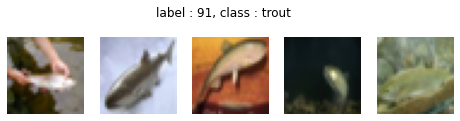

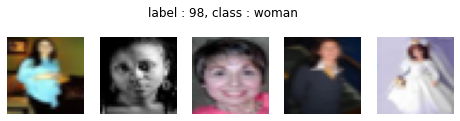

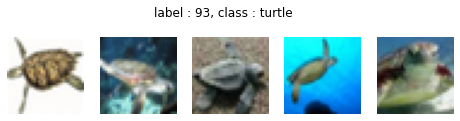

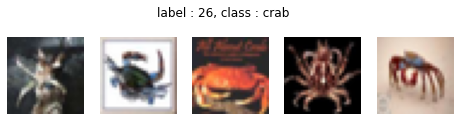

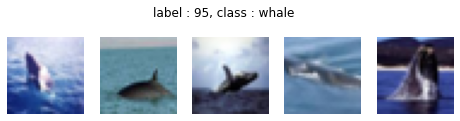

In [16]:
num_classes= 5 # Number of classes visualized
num_samples= 5 # Number of samples from each class

class_plotted = np.random.choice(range(n_classes),num_classes, replace = False)

for i in range(len(class_plotted)):
    image_samples = X[y.reshape(-1) == class_plotted[i]][:num_samples]
    fig, ax = plt.subplots(nrows = 1, ncols = num_samples, figsize=(8,2) )
    fig.suptitle("label : %d, class : %s" % (class_plotted[i], 
                                             fine_label_list[class_plotted[i]]))
    for j in range(num_samples):
        ax[j].imshow(image_samples[j])
        ax[j].axis('off') 

plt.show()

# Visualizing HOG

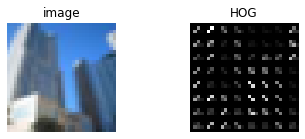

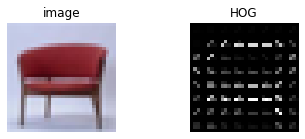

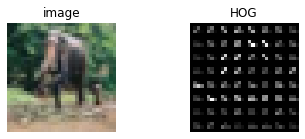

In [13]:
for i in range(3):
  image = X[i]
  fd, hog_image = hog(image,pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block, visualize=True,
                      multichannel=True)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))

  ax1.axis('off')
  ax1.imshow(image, cmap=plt.cm.gray)
  ax1.set_title("image")

  ax2.axis('off')
  ax2.imshow(hog_image, cmap=plt.cm.gray)
  ax2.set_title('HOG')
  plt.show()

# Data subsampling

In [14]:
# Memory error prevention by subsampling data
num_training = 50000
mask = list(range(num_training))
X = X[mask]
y = y[mask]

num_test = 5000
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]
print("Sampled training data shape : ",X.shape)
print("Sampled testing data shape : ",X_test.shape)

Sampled training data shape :  (50000, 32, 32, 3)
Sampled testing data shape :  (5000, 32, 32, 3)


# Image Preprocessing

In [15]:
train_HOG = []
test_HOG = []

# X = [ color.rgb2gray(i) for i in X]
# X_test = [ color.rgb2gray(i) for i in X_test]

for i in range(len(X)):
  fd = hog( X[i], pixels_per_cell= pixels_per_cell, 
           cells_per_block= cells_per_block, multichannel=True)
  train_HOG.append(fd)

for i in range(len(X_test)):
  fd = hog( X_test[i], pixels_per_cell= pixels_per_cell,
           cells_per_block= cells_per_block, multichannel=True)
  test_HOG.append(fd)

train_HOG = np.array(train_HOG)
test_HOG = np.array(test_HOG)

print("Train HOG shape : ",train_HOG.shape)
print("Test HOG shape : ",test_HOG.shape)

Train HOG shape :  (50000, 576)
Test HOG shape :  (5000, 576)


# KMeans

In [ ]:
class KMeans:
    
    def __init__(self,n_clusters=10,max_iter=500):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.loss_per_iteration = []

    def init_centroids(self):
        np.random.seed(np.random.randint(0,100000))
        self.centroids = []
        for i in range(self.n_clusters):
            rand_index = np.random.choice(range(len(self.fit_data)))
            self.centroids.append(self.fit_data[rand_index])
    
    def init_clusters(self):
        self.clusters = {'data':{i:[] for i in range(self.n_clusters)}}
        self.clusters['labels']={i:[] for i in range(self.n_clusters)}

    def fit(self,fit_data,fit_labels):
        self.fit_data = fit_data
        self.fit_labels = fit_labels
        self.predicted_labels = [None for _ in range(self.fit_data.shape[0])]
        self.init_centroids()
        self.iterations = 0
        old_centroids = [np.zeros(shape=(fit_data.shape[1],)) for _ in range(self.n_clusters)]
        while not self.converged(self.iterations,old_centroids,self.centroids):
            old_centroids = copy.deepcopy(self.centroids)
            self.init_clusters()
            for j,sample in tqdm(enumerate(self.fit_data)):
                min_dist = float('inf')
                for i,centroid in enumerate(self.centroids):
                    dist = np.linalg.norm(sample-centroid)
                    if dist<min_dist:
                        min_dist = dist
                        self.predicted_labels[j] = i
                if self.predicted_labels[j] is not None:
                        self.clusters['data'][self.predicted_labels[j]].append(sample)                    
                        self.clusters['labels'][self.predicted_labels[j]].append(self.fit_labels[j])
            self.reshape_cluster()
            self.update_centroids()
            self.calculate_loss()
            print("\nIteration:",self.iterations,'Loss:',self.loss,'Difference:',self.centroids_dist)
            self.iterations+=1
        self.calculate_accuracy()

    def update_centroids(self):
        for i in range(self.n_clusters):
            cluster = self.clusters['data'][i]
            if cluster == []:
                self.centroids[i] = self.fit_data[np.random.choice(range(len(self.fit_data)))]
            else:
                self.centroids[i] = np.mean(np.vstack((self.centroids[i],cluster)),axis=0)
    
    def reshape_cluster(self):
        for id,mat in list(self.clusters['data'].items()):
            self.clusters['data'][id] = np.array(mat)

    def converged(self,iterations,centroids,updated_centroids):
        if iterations > self.max_iter:
            return True
        self.centroids_dist = np.linalg.norm(np.array(updated_centroids)-np.array(centroids))
        if self.centroids_dist<=1e-10:
            print("Converged! With distance:",self.centroids_dist)
            return True
        return False

    def calculate_loss(self):
        self.loss = 0
        for key,value in list(self.clusters['data'].items()):
            if value is not None:
                for v in value:
                    self.loss += np.linalg.norm(v-self.centroids[key])
        self.loss_per_iteration.append(self.loss)
    
    def calculate_accuracy(self):
        self.clusters_labels = []
        self.clusters_info = []
        self.clusters_accuracy = []
        for clust,labels in list(self.clusters['labels'].items()):
            if isinstance(labels[0],(np.ndarray)):
                labels = [l[0] for l in labels]
            occur = 0
            max_label = max(set(labels), key=labels.count)
            self.clusters_labels.append(max_label)
            for label in labels:
                if label == max_label:
                    occur+=1
            acc = occur/len(list(labels))
            self.clusters_info.append([max_label,occur,len(list(labels)),acc])
            self.clusters_accuracy.append(acc)
            self.accuracy = sum(self.clusters_accuracy)/self.n_clusters
        self.labels_ = []
        for i in range(len(self.predicted_labels)):
            self.labels_.append(self.clusters_labels[self.predicted_labels[i]])
        #print('[cluster_label,no_occurence_of_label,total_samples_in_cluster,cluster_accuracy]',self.clusters_info)
        #print('Accuracy:',self.accuracy)
        return self.accuracy ,np.array(self.clusters_info)


# Training Model

In [ ]:
model = KMeans(n_clusters=n_clusters,max_iter=epochs)
model.fit(train_HOG, y)

45000it [00:33, 1360.61it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.



Iteration: 0 Loss: 35350.22841560961 Difference: 9.999999999444125


45000it [00:32, 1375.28it/s]



Iteration: 1 Loss: 34759.333937487776 Difference: 6.588001031875739


45000it [00:32, 1366.18it/s]



Iteration: 2 Loss: 34613.26791377448 Difference: 0.8822282335103491


45000it [00:32, 1372.81it/s]



Iteration: 3 Loss: 34544.04129312083 Difference: 0.5119179034424874


45000it [00:33, 1361.74it/s]



Iteration: 4 Loss: 34504.09197652812 Difference: 0.3703464346234656


45000it [00:32, 1367.32it/s]



Iteration: 5 Loss: 34478.058530380855 Difference: 0.28595113215151247


45000it [00:32, 1374.25it/s]



Iteration: 6 Loss: 34459.044106956026 Difference: 0.23804696955618712


45000it [00:33, 1359.85it/s]



Iteration: 7 Loss: 34444.491316007414 Difference: 0.20874537701134976


45000it [00:32, 1371.38it/s]



Iteration: 8 Loss: 34432.83211123332 Difference: 0.18485809666469372


45000it [00:32, 1368.73it/s]



Iteration: 9 Loss: 34422.30546108801 Difference: 0.16797519494142674


45000it [00:32, 1370.57it/s]



Iteration: 10 Loss: 34413.22862221941 Difference: 0.15872098272177826


45000it [00:32, 1366.18it/s]



Iteration: 11 Loss: 34405.37665156489 Difference: 0.14757790403323642


45000it [00:32, 1370.58it/s]



Iteration: 12 Loss: 34399.25791489646 Difference: 0.13947988774285872


45000it [00:33, 1360.39it/s]



Iteration: 13 Loss: 34394.79026377298 Difference: 0.12113580701694779


45000it [00:32, 1373.46it/s]



Iteration: 14 Loss: 34391.183369747545 Difference: 0.1043164638412671


45000it [00:32, 1380.59it/s]



Iteration: 15 Loss: 34388.25038691244 Difference: 0.0949973893995932


45000it [00:32, 1367.70it/s]



Iteration: 16 Loss: 34385.703524046774 Difference: 0.08708875529365402


45000it [00:33, 1362.67it/s]



Iteration: 17 Loss: 34383.49668413891 Difference: 0.08006042969274359


45000it [00:32, 1366.45it/s]



Iteration: 18 Loss: 34381.54952925049 Difference: 0.07591584503667416


45000it [00:32, 1367.51it/s]



Iteration: 19 Loss: 34379.871553903155 Difference: 0.07223615756626513


45000it [00:32, 1369.38it/s]



Iteration: 20 Loss: 34378.66058036117 Difference: 0.06521694117899378


45000it [00:33, 1362.24it/s]



Iteration: 21 Loss: 34377.711203165156 Difference: 0.05731047190451519


45000it [00:33, 1362.47it/s]



Iteration: 22 Loss: 34376.884838062826 Difference: 0.049660946735334936


45000it [00:32, 1367.55it/s]



Iteration: 23 Loss: 34376.07709771913 Difference: 0.04784458426322319


45000it [00:33, 1361.33it/s]



Iteration: 24 Loss: 34375.429314582696 Difference: 0.04625285328246359


45000it [00:32, 1367.59it/s]



Iteration: 25 Loss: 34374.87563599787 Difference: 0.042142784677548936


45000it [00:32, 1376.58it/s]



Iteration: 26 Loss: 34374.25246588207 Difference: 0.03929854974948431


45000it [00:32, 1369.38it/s]



Iteration: 27 Loss: 34373.66442169214 Difference: 0.04142967612082451


45000it [00:33, 1361.75it/s]



Iteration: 28 Loss: 34373.15895377921 Difference: 0.039690439216939925


45000it [00:33, 1350.84it/s]



Iteration: 29 Loss: 34372.642823501876 Difference: 0.03700929348693297


45000it [00:33, 1354.13it/s]



Iteration: 30 Loss: 34372.18225257763 Difference: 0.038220609041243976


45000it [00:32, 1364.12it/s]



Iteration: 31 Loss: 34371.72577421099 Difference: 0.03722962674658454


45000it [00:33, 1350.99it/s]



Iteration: 32 Loss: 34371.322283016656 Difference: 0.03659425003360872


45000it [00:33, 1353.92it/s]



Iteration: 33 Loss: 34370.93305137398 Difference: 0.03444516744233709


45000it [00:33, 1358.09it/s]



Iteration: 34 Loss: 34370.56925097657 Difference: 0.03369268209716438


45000it [00:32, 1366.85it/s]



Iteration: 35 Loss: 34370.237441408986 Difference: 0.031537111492892934


45000it [00:33, 1353.57it/s]



Iteration: 36 Loss: 34369.923575990644 Difference: 0.029619747507669447


45000it [00:33, 1360.74it/s]



Iteration: 37 Loss: 34369.66661155633 Difference: 0.02852046960161931


45000it [00:33, 1351.67it/s]



Iteration: 38 Loss: 34369.47253857015 Difference: 0.026165306427590077


45000it [00:32, 1367.67it/s]



Iteration: 39 Loss: 34369.311320602166 Difference: 0.02311429804738554


45000it [00:32, 1366.51it/s]



Iteration: 40 Loss: 34369.157338026256 Difference: 0.021231503203598855


45000it [00:32, 1367.45it/s]



Iteration: 41 Loss: 34369.00450171217 Difference: 0.021166405027102007


45000it [00:32, 1370.91it/s]



Iteration: 42 Loss: 34368.86006719503 Difference: 0.022299789021454974


45000it [00:32, 1369.92it/s]



Iteration: 43 Loss: 34368.759651614324 Difference: 0.020427211040159918


45000it [00:32, 1373.52it/s]



Iteration: 44 Loss: 34368.68096490606 Difference: 0.017205530841702704


45000it [00:32, 1367.40it/s]



Iteration: 45 Loss: 34368.627412546935 Difference: 0.015062472360231298


45000it [00:32, 1367.64it/s]



Iteration: 46 Loss: 34368.58350896347 Difference: 0.012394257248225966


45000it [00:32, 1365.15it/s]



Iteration: 47 Loss: 34368.540600838984 Difference: 0.011244625907163273


45000it [00:32, 1365.30it/s]



Iteration: 48 Loss: 34368.50430717837 Difference: 0.011366191599386514


45000it [00:33, 1359.77it/s]



Iteration: 49 Loss: 34368.4758651521 Difference: 0.010379917616171441


45000it [00:32, 1366.23it/s]



Iteration: 50 Loss: 34368.43141455865 Difference: 0.008960236251567347


45000it [00:32, 1366.96it/s]



Iteration: 51 Loss: 34368.391279503594 Difference: 0.011222612101991098


45000it [00:32, 1367.41it/s]



Iteration: 52 Loss: 34368.34594427208 Difference: 0.01057541365560997


45000it [00:33, 1363.49it/s]



Iteration: 53 Loss: 34368.3012404889 Difference: 0.011213239357161795


45000it [00:33, 1362.70it/s]



Iteration: 54 Loss: 34368.230944082745 Difference: 0.01181335395502787


45000it [00:33, 1358.14it/s]



Iteration: 55 Loss: 34368.14287540641 Difference: 0.015272994898454524


45000it [00:33, 1362.51it/s]



Iteration: 56 Loss: 34368.05253094744 Difference: 0.017158414974462927


45000it [00:32, 1364.86it/s]



Iteration: 57 Loss: 34367.95173881293 Difference: 0.016430032142835897


45000it [00:33, 1346.04it/s]



Iteration: 58 Loss: 34367.82392691651 Difference: 0.01771624579899348


45000it [00:33, 1359.46it/s]



Iteration: 59 Loss: 34367.680643209846 Difference: 0.020414245267418103


45000it [00:32, 1366.19it/s]



Iteration: 60 Loss: 34367.52415157896 Difference: 0.02139283196286343


45000it [00:32, 1364.77it/s]



Iteration: 61 Loss: 34367.36194772592 Difference: 0.022443065510362455


45000it [00:32, 1366.53it/s]



Iteration: 62 Loss: 34367.208192207276 Difference: 0.021198150645618176


45000it [00:33, 1359.42it/s]



Iteration: 63 Loss: 34367.052156227604 Difference: 0.02058211839975867


45000it [00:33, 1356.46it/s]



Iteration: 64 Loss: 34366.90797972299 Difference: 0.021970175145443565


45000it [00:33, 1353.03it/s]



Iteration: 65 Loss: 34366.75767429452 Difference: 0.020963655141239632


45000it [00:33, 1353.11it/s]



Iteration: 66 Loss: 34366.624784718806 Difference: 0.021125080956913296


45000it [00:33, 1357.89it/s]



Iteration: 67 Loss: 34366.49685999415 Difference: 0.019067869592967048


45000it [00:33, 1355.34it/s]



Iteration: 68 Loss: 34366.32968522697 Difference: 0.018687763630395926


45000it [00:32, 1365.25it/s]



Iteration: 69 Loss: 34366.16666801188 Difference: 0.020606547320420256


45000it [00:33, 1359.72it/s]



Iteration: 70 Loss: 34365.97608753029 Difference: 0.01967629651372866


45000it [00:33, 1352.36it/s]



Iteration: 71 Loss: 34365.79124139542 Difference: 0.02235305051181138


45000it [00:32, 1364.33it/s]



Iteration: 72 Loss: 34365.54579927394 Difference: 0.022234346396332233


45000it [00:33, 1360.31it/s]



Iteration: 73 Loss: 34365.34254637537 Difference: 0.025223771675706132


45000it [00:33, 1361.48it/s]



Iteration: 74 Loss: 34365.195203548654 Difference: 0.022819542940107674


45000it [00:33, 1350.47it/s]



Iteration: 75 Loss: 34365.04600281693 Difference: 0.01956195810348408


45000it [00:33, 1356.88it/s]



Iteration: 76 Loss: 34364.90649867523 Difference: 0.02153820841665448


45000it [00:33, 1362.71it/s]



Iteration: 77 Loss: 34364.79916716293 Difference: 0.02109337844586408


45000it [00:33, 1361.43it/s]



Iteration: 78 Loss: 34364.69534637398 Difference: 0.017286183739564132


45000it [00:33, 1363.15it/s]



Iteration: 79 Loss: 34364.607460325904 Difference: 0.017986214706089958


45000it [00:33, 1356.35it/s]



Iteration: 80 Loss: 34364.546596457316 Difference: 0.015757433956794534


45000it [00:33, 1359.44it/s]



Iteration: 81 Loss: 34364.484486428206 Difference: 0.013160518985922107


45000it [00:33, 1363.17it/s]



Iteration: 82 Loss: 34364.426512939855 Difference: 0.013588703266366714


45000it [00:33, 1356.64it/s]



Iteration: 83 Loss: 34364.376079206275 Difference: 0.01258555079739845


45000it [00:33, 1360.01it/s]



Iteration: 84 Loss: 34364.34002589956 Difference: 0.0128596670977969


45000it [00:33, 1351.26it/s]



Iteration: 85 Loss: 34364.29724641012 Difference: 0.01052745330470156


45000it [00:33, 1356.62it/s]



Iteration: 86 Loss: 34364.261290261566 Difference: 0.011282890115539316


45000it [00:33, 1359.22it/s]



Iteration: 87 Loss: 34364.2252492454 Difference: 0.010419754329052523


45000it [00:33, 1347.55it/s]



Iteration: 88 Loss: 34364.20253072426 Difference: 0.011257628703823158


45000it [00:33, 1363.55it/s]



Iteration: 89 Loss: 34364.18749967639 Difference: 0.007621508057480704


45000it [00:33, 1357.20it/s]



Iteration: 90 Loss: 34364.18313633086 Difference: 0.007412105670484638


45000it [00:32, 1366.85it/s]



Iteration: 91 Loss: 34364.17982479938 Difference: 0.0034563435502924875


45000it [00:33, 1356.85it/s]



Iteration: 92 Loss: 34364.17841086801 Difference: 0.0033273362601404927


45000it [00:33, 1357.42it/s]



Iteration: 93 Loss: 34364.17841087243 Difference: 0.0018652189318287622


45000it [00:33, 1336.50it/s]



Iteration: 94 Loss: 34364.178410872424 Difference: 3.317036605331123e-06


45000it [00:33, 1356.47it/s]



Iteration: 95 Loss: 34364.17841087242 Difference: 5.947883573169676e-09
Converged! With distance: 1.0746755066375981e-11


# Testing Model

In [ ]:
test_accuracy, info = model.calculate_accuracy()
test_accuracy*=100

testdf = pd.DataFrame(info ,
                      columns=['cluster_label',
                               'no_occurence_of_label',
                               'total_samples_in_cluster','cluster_accuracy'] )
testdf.cluster_accuracy *= 100
#testdf.set_index('cluster_label', inplace=True)

for i in range(len(testdf.cluster_label)):
  testdf.cluster_label[i] = fine_label_list[ int(testdf.cluster_label[i] ) ]

testdf        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,cluster_label,no_occurence_of_label,total_samples_in_cluster,cluster_accuracy
0,wardrobe,26.0,412.0,6.310680
1,cup,49.0,313.0,15.654952
2,porcupine,41.0,595.0,6.890756
3,train,33.0,358.0,9.217877
4,bottle,33.0,240.0,13.750000
...,...,...,...,...
95,plain,92.0,413.0,22.276029
96,shark,37.0,367.0,10.081744
97,wardrobe,150.0,448.0,33.482143
98,beetle,21.0,422.0,4.976303


# Visualizing Test Results

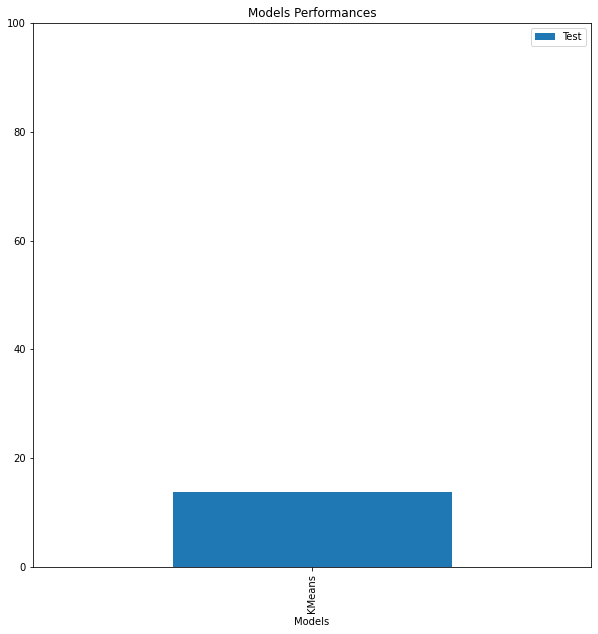

In [ ]:
df = pd.DataFrame([['KMeans' , test_accuracy]],
                  columns=['Models', 'Test'])
df.plot(x='Models',
        kind='bar',
        stacked=False,
        figsize=(10,10),
        ylim=(0,100),
        title='Models Performances')